In [1]:
from IPython.display import display, Markdown

import sys
import os
from pathlib import Path

# Определяем путь к директории ноутбука
# Простое решение: определяем папку, где находится файл ноутбука
notebook_dir = None

# Способ 1: Используем библиотеку ipynbname (самый надежный способ)
# Если библиотека не установлена, она будет установлена автоматически
try:
    import ipynbname
    nb_path = ipynbname.path()
    if nb_path:
        notebook_dir = str(Path(nb_path).parent.resolve())
except ImportError:
    # Устанавливаем библиотеку, если её нет
    import subprocess
    import sys
    print("📦 Устанавливаю библиотеку ipynbname для определения пути к ноутбуку...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ipynbname", "-q"])
    import ipynbname
    nb_path = ipynbname.path()
    if nb_path:
        notebook_dir = str(Path(nb_path).parent.resolve())
except Exception as e:
    print(f"⚠️  Не удалось использовать ipynbname: {e}")

# Способ 2: Пробуем получить путь через IPython (запасной вариант)
if notebook_dir is None:
    try:
        from IPython import get_ipython
        ipython = get_ipython()
        if ipython is not None:
            if hasattr(ipython, 'start_dir'):
                notebook_dir = str(Path(ipython.start_dir).resolve())
    except:
        pass

# Способ 3: Если не удалось определить, выводим ошибку
if notebook_dir is None:
    print(f"❌ ОШИБКА: Не удалось определить папку ноутбука!")
    print(f"   Текущая рабочая директория: {os.getcwd()}")
    print(f"   Установите библиотеку: pip install ipynbname")
    raise RuntimeError("Не удалось определить директорию ноутбука. Установите: pip install ipynbname")

# Выводим информацию для диагностики
print(f"📂 Директория ноутбука: {notebook_dir}")
print(f"📂 Текущая рабочая директория (до chdir): {os.getcwd()}")

# Добавляем путь к директории ноутбука в sys.path (в начало для приоритета)
if notebook_dir not in sys.path:
    sys.path.insert(0, notebook_dir)

# Меняем рабочую директорию на директорию ноутбука, чтобы относительные пути работали
os.chdir(notebook_dir)
print(f"📂 Рабочая директория установлена: {os.getcwd()}")

📂 Директория ноутбука: C:\Users\stepu\OneDrive\IDE\skillfactory\Блок 8\MATH&ML-12. Временные ряды. Часть I
📂 Текущая рабочая директория (до chdir): c:\Users\stepu\OneDrive\IDE
📂 Рабочая директория установлена: C:\Users\stepu\OneDrive\IDE\skillfactory\Блок 8\MATH&ML-12. Временные ряды. Часть I


In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
import statsmodels.api as sm

from datetime import datetime

df = pd.read_csv("./data/tovar_moving.csv",parse_dates=['date'], index_col=['date']) # считываем датасет
df.head() 

,qty
date,
2009-12-25,72314.0
2009-12-26,66586.0
2009-12-27,125199.0
2009-12-28,91544.0
2009-12-29,76995.0


<Axes: xlabel='date'>

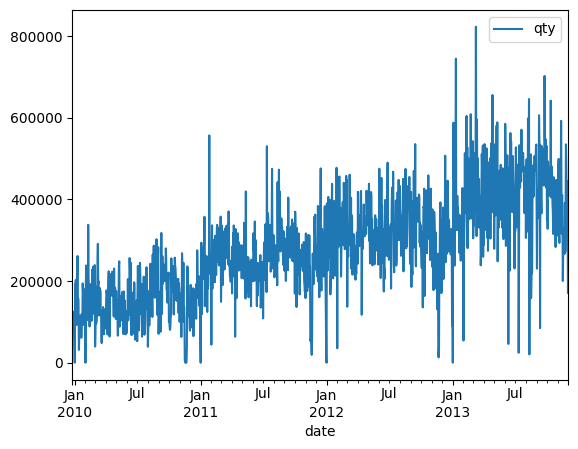

In [3]:
df.plot()

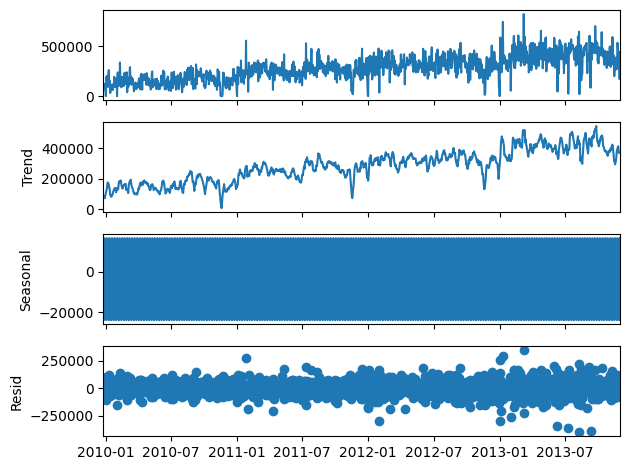

In [4]:
decomposition = seasonal_decompose(df, model='additive') 
decomposition.plot()
pyplot.show() # любуемся результатом

In [5]:
test_df = df.iloc[-1]
train_df = df.iloc[:-1]
test_df

qty    423846.0
Name: 2013-12-02 00:00:00, dtype: float64

In [6]:
from statsmodels.tsa.api import SimpleExpSmoothing
ses = SimpleExpSmoothing(train_df)
alpha = 0.7
model = ses.fit(smoothing_level = alpha, optimized = False)
exp_pred = model.forecast(1)
exp_pred

c:\Users\stepu\OneDrive\IDE\.venv313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


2013-12-02    225015.522647
Freq: D, dtype: float64

In [7]:
model.forecast(4)

2013-12-02    225015.522647
2013-12-03    225015.522647
2013-12-04    225015.522647
2013-12-05    225015.522647
Freq: D, dtype: float64

In [8]:
def stat_test(df):
    test = sm.tsa.adfuller(df)
    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')

stat_test(train_df)

adf:  -2.255302641033783
p-value:  0.1867890312341704
Critical values:  {'1%': -3.434973278556316, '5%': -2.8635818545830376, '10%': -2.567857072940785}
есть единичные корни, ряд не стационарен


In [9]:
otg1diff = df.diff(periods=1).dropna()

In [10]:
stat_test(otg1diff)

adf:  -13.82183986522638
p-value:  7.878856681058509e-26
Critical values:  {'1%': -3.4349700122033804, '5%': -2.8635804131233096, '10%': -2.567856305330816}
единичных корней нет, ряд стационарен


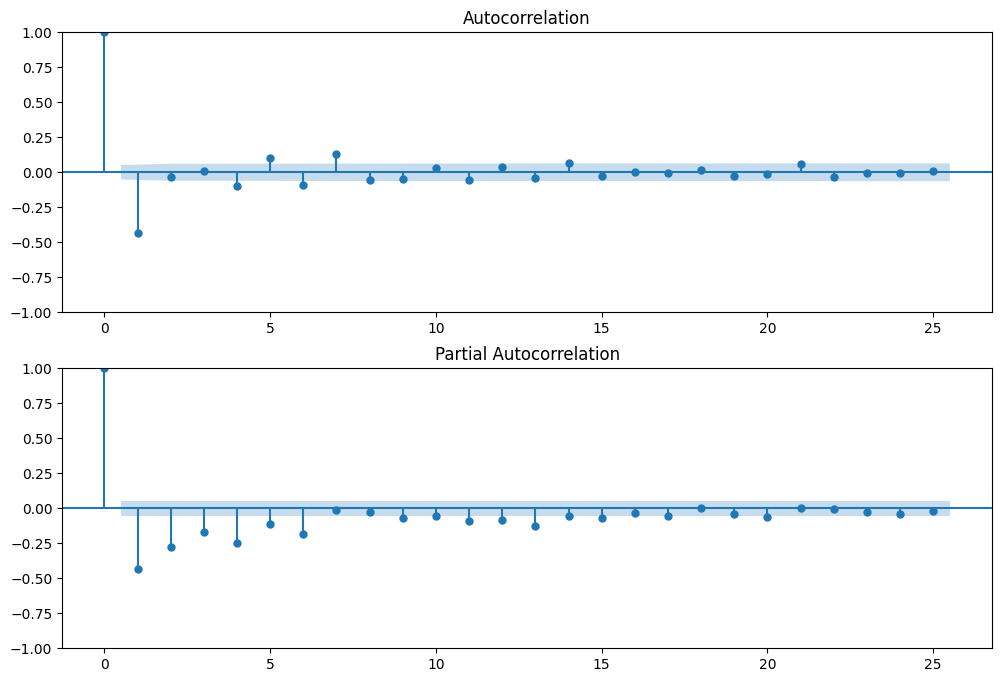

In [11]:
from matplotlib import pyplot as plt
%matplotlib inline 

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(otg1diff.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(otg1diff, lags=25, ax=ax2)

по pacf видим что последним лагом, отличным от нуля является 6 лаг.

In [12]:
p =6
len(train_df)

1438

In [13]:
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg

ar_model = AutoReg(train_df, lags=p).fit()
print(ar_model.summary())

ar_pred = ar_model.predict(start=len(train_df), end=(len(train_df)), dynamic=False)
ar_pred

                            AutoReg Model Results                             
Dep. Variable:                    qty   No. Observations:                 1438
Model:                     AutoReg(6)   Log Likelihood              -18221.056
Method:               Conditional MLE   S.D. of innovations          81248.064
Date:                Tue, 25 Nov 2025   AIC                          36458.111
Time:                        10:58:33   BIC                          36500.246
Sample:                    12-31-2009   HQIC                         36473.844
                         - 12-01-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.047e+04   6160.175      4.946      0.000    1.84e+04    4.25e+04
qty.L1         0.3074      0.026     11.654      0.000       0.256       0.359
qty.L2         0.1582      0.027      5.835      0.0

c:\Users\stepu\OneDrive\IDE\.venv313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\stepu\OneDrive\IDE\.venv313\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


2013-12-02    318174.284553
Freq: D, dtype: float64

In [14]:
from sklearn.metrics import mean_squared_error

mean_squared_error(test_df, ar_pred) < mean_squared_error(test_df, exp_pred)

True